In [79]:
import pandas as pd

In [80]:
from google.colab import drive
drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Tech Challenge 4/Obesity.csv'

path = '/content/drive/MyDrive/Pós Tech/Tech Challenges/Tech Challenge 4/Ramos/obesity_tratado.parquet'
#df = pd.read_csv(path)

df = pd.read_parquet(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Avaliando e Tratando os dados


In [100]:
# Substituindo gênero
df['gender'] = df['gender'].replace(['Feminino','Masculino'],[0,1])

/tmp/ipython-input-100-1409270993.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(['Feminino','Masculino'],[0,1])


<Axes: >

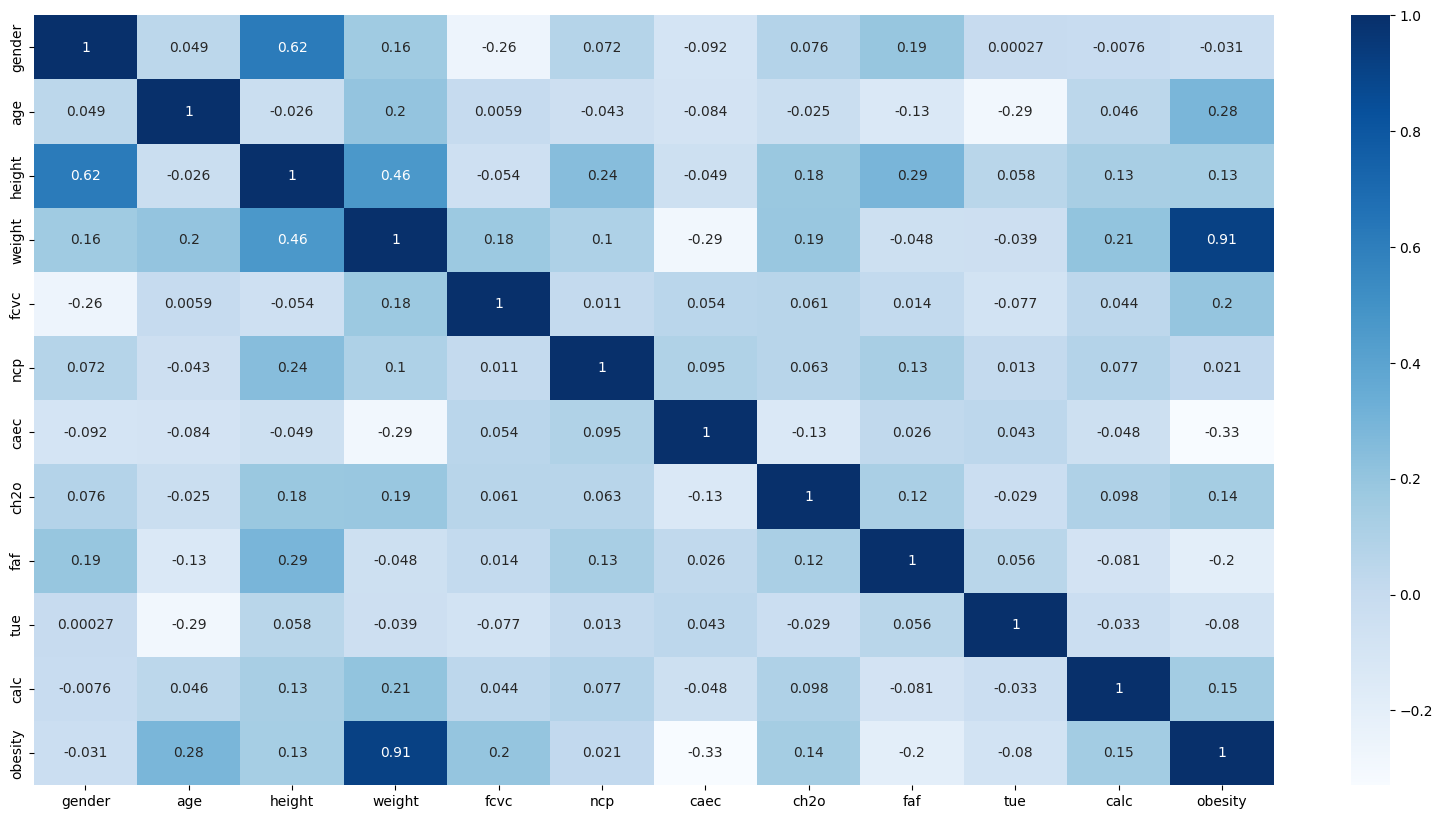

In [102]:
# Criando a matriz de correlação
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.select_dtypes(include='number').corr()
plt.figure(figsize = (20,10))
sns.heatmap(corr, cmap="Blues", annot=True)

In [105]:
# Contar e agrupar pela categoria da coluna obesidade
df['obesity'].groupby(df['obesity']).count()

,obesity
obesity,
0,1139
1,972


## Tratando a variável target

In [104]:
# Transforma a variável target "Obesity" em apenas duas categorias

def ajusta_variavel_target(cat):
    if cat in [0, 1, 2, 3]:
        return 0
    else:
        return 1

df['obesity'] = df['obesity'].apply(ajusta_variavel_target)

## Exporta dados para BI

In [143]:
path_gold = '/content/drive/MyDrive/Pós Tech/Tech Challenges/Tech Challenge 4/Ramos/obesity_tratado.csv'
df.to_csv(path_gold, index=False)

## Construindo a Pipeline

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
SEED = 4658751

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

In [110]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE

In [111]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['weight']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print('Uma ou mais features não estão no DataFrame')
            return df

In [112]:
class MinMax(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler  = ['age', 'weight', 'height']):
        self.min_max_scaler = min_max_scaler
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler] = min_max_enc.fit_transform(df[self.min_max_scaler ])
            return df
        else:
            print('Uma ou mais features não estão no DataFrame')
            return df

In [113]:
class OneHotEncodingNames(BaseEstimator,TransformerMixin):
    def __init__(self,OneHotEncoding = ['mtrans']):

        self.OneHotEncoding = OneHotEncoding

    def fit(self,df):
        return self

    def transform(self,df):
        if (set(self.OneHotEncoding).issubset(df.columns)):
            # função para one-hot-encoding das features
            def one_hot_enc(df,OneHotEncoding):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[OneHotEncoding])
                # obtendo o resultado dos nomes das colunas
                feature_names = one_hot_enc.get_feature_names_out(OneHotEncoding)
                # mudando o array do one hot encoding para um dataframe com os nomes das colunas
                df = pd.DataFrame(one_hot_enc.transform(df[self.OneHotEncoding]).toarray(),
                                  columns= feature_names,index=df.index)
                return df

            # função para concatenar as features com aquelas que não passaram pelo one-hot-encoding
            def concat_with_rest(df,one_hot_enc_df,OneHotEncoding):
                # get the rest of the features
                outras_features = [feature for feature in df.columns if feature not in OneHotEncoding]
                # concaternar o restante das features com as features que passaram pelo one-hot-encoding
                df_concat = pd.concat([one_hot_enc_df, df[outras_features]],axis=1)
                return df_concat

            # one hot encoded dataframe
            df_OneHotEncoding = one_hot_enc(df,self.OneHotEncoding)

            # retorna o dataframe concatenado
            df_full = concat_with_rest(df, df_OneHotEncoding,self.OneHotEncoding)
            return df_full

        else:
            print('Uma ou mais features não estão no DataFrame')
            missing = set(self.OneHotEncoding) - set(df.columns)
            print(f"Colunas ausentes no DataFrame: {missing}")
            return df

In [114]:
class OrdinalFeature(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_feature = ['fcvc','ncp', 'caec', 'ch2o', 'faf', 'tue', 'calc']):
        self.ordinal_feature = ordinal_feature
    def fit(self,df):
        return self
    def transform(self,df):
        for ordinal in self.ordinal_feature:
          if ordinal in df.columns:
              ordinal_encoder = OrdinalEncoder()
              df[self.ordinal_feature] = ordinal_encoder.fit_transform(df[self.ordinal_feature])
              return df
          else:
              print(f"{ordinal} não está no DataFrame")
              return df

In [115]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'obesity' in df.columns:
            # função smote para superamostrar a classe minoritária para corrigir os dados desbalanceados
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'obesity'], df['obesity'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("O target não está no DataFrame")
            return df

In [116]:
from sklearn.pipeline import Pipeline

In [117]:
def pipeline(df):

    pipeline = Pipeline([
        ('OneHotEncoding', OneHotEncodingNames()),
        ('ordinal_feature', OrdinalFeature()),
        ('min_max_scaler', MinMax()),
        ('oversample', Oversample())
    ])
    df_pipeline = pipeline.fit_transform(df)
    return df_pipeline

## Escolhendo o melhor modelo

In [119]:
train = pipeline(train_df)

In [ ]:
train.head()

,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Gender,Age,Height,Weight,family_history,...,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Obesity
0,0.0,0.0,0.0,0.0,1.0,1,0.380952,0.566038,0.253731,1,...,0.500000,0.666667,3.0,0,0.500000,1,0.333333,0.000000,2.0,0
1,0.0,0.0,0.0,1.0,0.0,1,0.261905,0.622642,0.440299,1,...,0.500000,0.666667,2.0,0,1.000000,0,1.000000,1.000000,3.0,1
2,0.0,0.0,0.0,1.0,0.0,1,0.233969,0.629451,0.611355,1,...,0.795646,0.652141,2.0,0,0.655415,0,0.495080,0.140907,2.0,1
3,0.0,0.0,0.0,1.0,0.0,0,0.273657,0.422009,0.490334,1,...,1.000000,0.666667,2.0,0,0.085257,0,0.088277,0.448421,2.0,1
4,0.0,0.0,0.0,1.0,0.0,1,0.284042,0.608394,0.492537,1,...,1.000000,0.666667,2.0,0,0.522534,0,0.575310,0.809798,2.0,1


In [120]:
X_train, y_train = train.loc[:, train.columns != 'obesity'], train['obesity']

In [121]:
test = pipeline(test_df)

In [122]:
test.head()

,mtrans_Automóvel,mtrans_Bicicleta,mtrans_Caminhada,mtrans_Motocicleta,mtrans_Transporte público,gender,age,height,weight,family_history,...,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,obesity
0,0.0,0.0,0.0,0.0,1.0,0,0.340426,0.100822,0.330873,True,...,1.0,1.0,1.0,False,1.0,False,0.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,0.0,1,0.170213,0.516827,0.304611,True,...,2.0,2.0,2.0,False,0.0,False,1.0,0.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0,0.085106,0.436298,0.087959,False,...,1.0,2.0,1.0,False,1.0,False,0.0,1.0,1.0,0
3,1.0,0.0,0.0,0.0,0.0,1,0.382979,0.572160,0.695954,True,...,2.0,2.0,1.0,False,1.0,False,1.0,0.0,1.0,1
4,0.0,0.0,0.0,0.0,1.0,0,0.148936,0.572148,0.142261,True,...,1.0,3.0,2.0,False,1.0,False,2.0,1.0,0.0,0


In [123]:
X_test, y_test= test.loc[:, test.columns != 'obesity'], test['obesity']

In [124]:
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import numpy as np

In [125]:
SEED = 4658751

def roda_modelo(modelo):


    # Treinando modelo com os dados de treino

    modelo.fit(X_train, y_train)

    # Calculando a probabilidade e calculando o AUC
    prob_predic = modelo.predict_proba(X_test)

    print(f"\n------------------------------Resultados {modelo}------------------------------\n")

    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC {auc}")

    # Separando a probabilidade de ser bom e mau, e calculando o KS
    #métrica KS: probabilidade de um cliente ser classificado como bom ou mau.
    data_nao_obeso = np.sort(modelo.predict_proba(X_test)[:, 0])
    data_obeso = np.sort(modelo.predict_proba(X_test)[:, 1])
    kstest = stats.ks_2samp(data_nao_obeso, data_obeso)

    print(f"Métrica KS: {kstest}")

    print("\nConfusion Matrix\n")
    # Criando matriz de confusão
    fig, ax = plt.subplots(figsize=(7,7))
    matriz_confusao = ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, normalize='true',
                                            display_labels=['Não Obeso', 'Obeso'],
                                            ax=ax, cmap=plt.cm.Blues)
    ax.set_title("Matriz de Confusão\n Normalizada", fontsize=16, fontweight="bold")
    ax.set_xlabel("Label predita", fontsize=18)
    ax.set_ylabel("Label verdadeira", fontsize=18)
    plt.grid(False)
    plt.show(matriz_confusao)

    # Fazendo a predicao dos dados de teste e calculando o classification report
    predicao = modelo.predict(X_test)
    print("\nClassification Report")
    print(classification_report(y_test, predicao, zero_division=0))


    print("\nRoc Curve\n")
    metrics.RocCurveDisplay.from_estimator(modelo, X_test, y_test)

In [126]:
def predict_obesity(modelo, values):
  predicao = modelo.predict(values)
  return predicao

In [127]:
from sklearn.linear_model import LogisticRegression
modelo_logistico = LogisticRegression()


------------------------------Resultados LogisticRegression()------------------------------

AUC 0.9967975757993147
Métrica KS: KstestResult(statistic=np.float64(0.22406639004149378), pvalue=np.float64(5.1628090113516086e-11), statistic_location=np.float64(0.2982621258442151), statistic_sign=np.int8(1))

Confusion Matrix



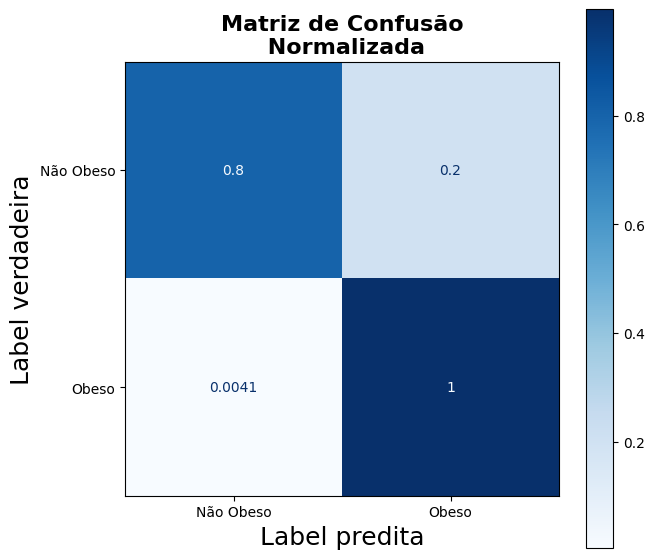


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       241
           1       0.83      1.00      0.91       241

    accuracy                           0.90       482
   macro avg       0.91      0.90      0.90       482
weighted avg       0.91      0.90      0.90       482


Roc Curve



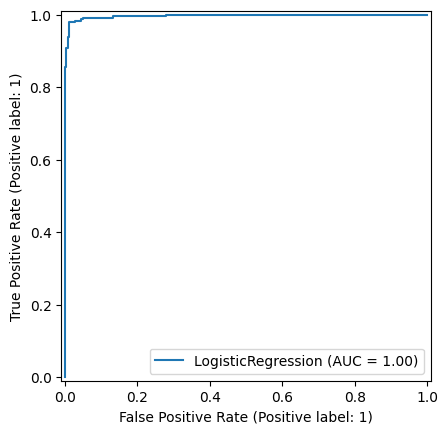

In [128]:
roda_modelo(modelo_logistico)

In [129]:
from sklearn.tree import DecisionTreeClassifier
modelo_tree = DecisionTreeClassifier()


------------------------------Resultados DecisionTreeClassifier()------------------------------

AUC 0.9128630705394191
Métrica KS: KstestResult(statistic=np.float64(0.17427385892116182), pvalue=np.float64(8.269984639019257e-07), statistic_location=np.float64(0.0), statistic_sign=np.int8(1))

Confusion Matrix



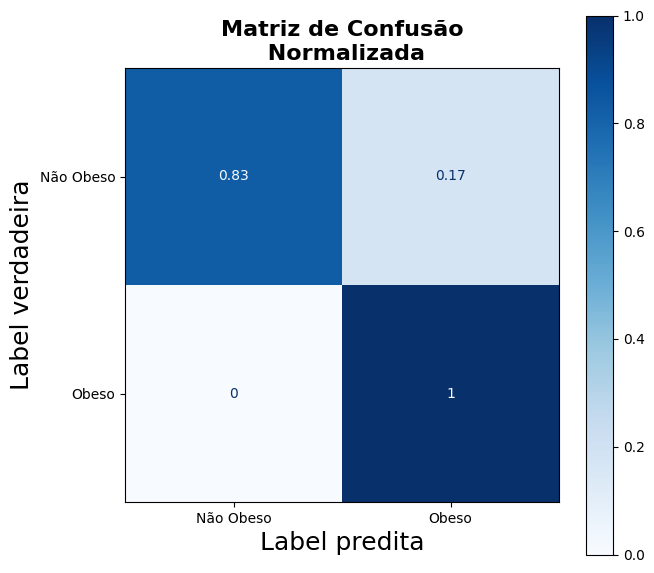


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90       241
           1       0.85      1.00      0.92       241

    accuracy                           0.91       482
   macro avg       0.93      0.91      0.91       482
weighted avg       0.93      0.91      0.91       482


Roc Curve



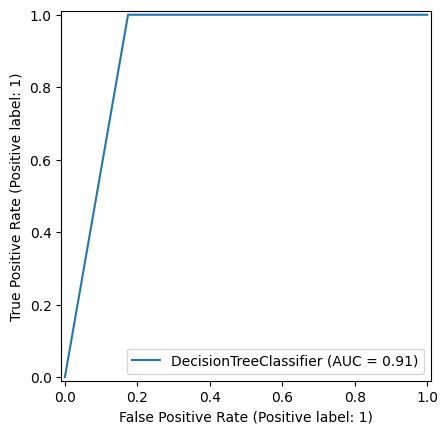

In [130]:
roda_modelo(modelo_tree)

In [136]:
from sklearn.ensemble import RandomForestClassifier
modelo_forest = RandomForestClassifier()


------------------------------Resultados RandomForestClassifier()------------------------------

AUC 0.9968320104681394
Métrica KS: KstestResult(statistic=np.float64(0.16804979253112035), pvalue=np.float64(2.330619770544738e-06), statistic_location=np.float64(0.04), statistic_sign=np.int8(1))

Confusion Matrix



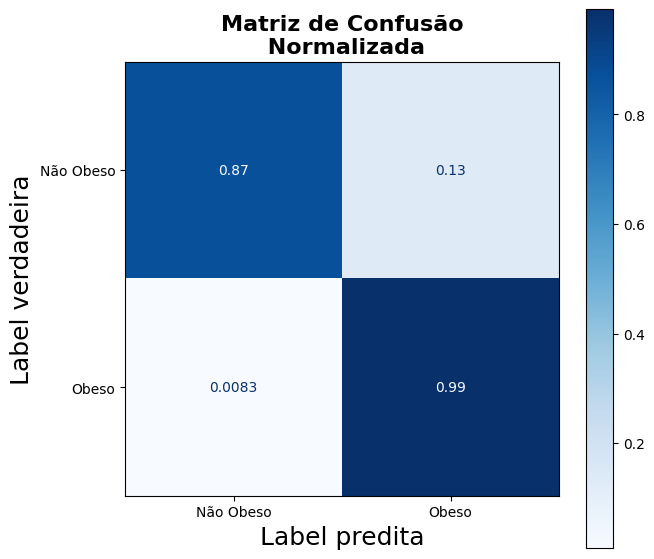


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       241
           1       0.89      0.99      0.94       241

    accuracy                           0.93       482
   macro avg       0.94      0.93      0.93       482
weighted avg       0.94      0.93      0.93       482


Roc Curve



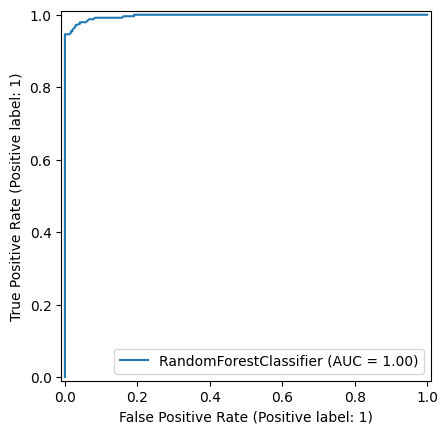

In [137]:
roda_modelo(modelo_forest)

In [138]:
from sklearn.ensemble import GradientBoostingClassifier
modelo_xgb = GradientBoostingClassifier()


------------------------------Resultados GradientBoostingClassifier()------------------------------

AUC 0.9968836624713762
Métrica KS: KstestResult(statistic=np.float64(0.27385892116182575), pvalue=np.float64(2.606730355472526e-16), statistic_location=np.float64(0.0008596571406961351), statistic_sign=np.int8(1))

Confusion Matrix



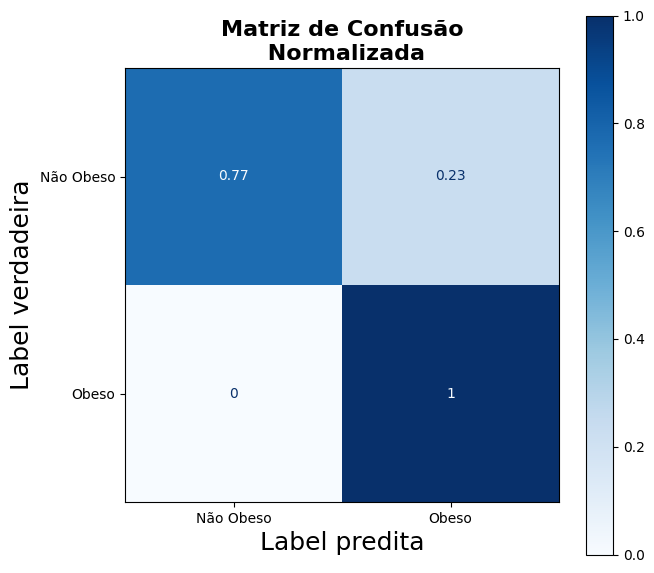


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       241
           1       0.81      1.00      0.90       241

    accuracy                           0.88       482
   macro avg       0.91      0.88      0.88       482
weighted avg       0.91      0.88      0.88       482


Roc Curve



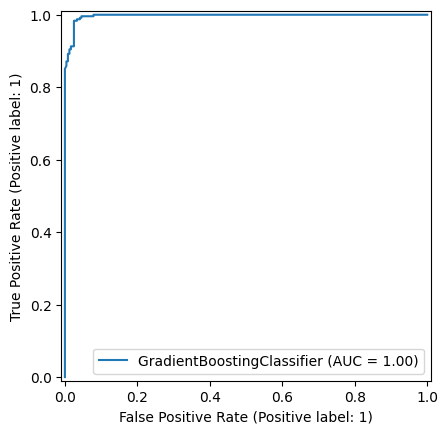

In [139]:
roda_modelo(modelo_xgb)

In [140]:
import joblib

In [141]:
joblib.dump(modelo_forest, 'forest.joblib')

['forest.joblib']